In [9]:
import numpy as np
from scipy.special import factorial
from arte.types.mask import CircularMask
from arte.utils.zernike_generator import ZernikeGenerator
from arte.atmo.von_karman_spatial_covariance_calculator import VonKarmanSpatialCovariance
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("error")

import numpy as np
from scipy.special import gamma
from arte.utils.zernike_generator import ZernikeGenerator

def kolm_covar(j1, j2):
    n1, m1 = ZernikeGenerator.degree(j1)
    n2, m2 = ZernikeGenerator.degree(j2)

    # Check if m1 is not equal to m2 or if the sum of j1 and j2 is odd and m1 is not zero
    if m1 != m2 or ((not is_even(j1 + j2)) and m1 != 0):
        return 0.0

    # Calculate npn and nmn
    npn = (n1 + n2) // 2 - 1
    nmn = abs(n1 - n2) // 2

    # Calculate the result using the constant from Roddier 1990, divided by 2*pi to convert rad to waves
    result = 0.057494899 * (-1)**((n1 + n2 - 2 * m1) // 2) * np.sqrt((n1 + 1) * (n2 + 1))
    result *= gamma(1.0 / 6.0) / (gamma(17.0 / 6.0))**2 / gamma(29.0 / 6.0)
    c1 = 1.0
    c2 = 1.0

    # Calculate c1 and c2
    if npn > 0:
        for i in range(npn):
            c1 *= (1.0 / 6.0 + i) / (29.0 / 6.0 + i)
    if nmn > 0:
        for i in range(nmn):
            c2 *= (-11.0 / 6.0 + i) / (17.0 / 6.0 + i)

    return result * c1 * c2 * (-1)**nmn

# Helper function to check if a number is even
def is_even(num):
    return num % 2 == 0

#bug explanation: not using VonKarmanSpatialCovariance.get_covariance() to get the covariance matrix anymore
print(kolm_covar(2, 436))
print(VonKarmanSpatialCovariance(2,436,np.inf).get_covariance())

7.917967140413132e-13
nan


In [10]:
#generate zernike modes and get covariance matrix
nzern=200
zz = ZernikeGenerator(CircularMask((200,200), 60, (100,100)))
zcube = np.rollaxis(np.ma.masked_array([zz.getZernike(n) for n in range(2,nzern+2)]),0,3)
zern_covar = np.zeros((nzern,nzern))
zern_covar2 = np.zeros((nzern,nzern))
for i in np.arange(2, nzern+2):
    for j in np.arange(2, nzern+2):
        zern_covar[i-2, j-2]=kolm_covar(i,j)
        # Compute the eigenvalues and eigenvectors


In [11]:
# Compute the eigenvalues and eigenvectors of the covariance matrix
U, S, Vt = np.linalg.svd(zern_covar)

In [12]:
# Project the Zernike modes onto the eigenmodes to find the KL modes
klcube = zcube.dot(Vt.T)
#remove the average from each kl mode
klcube = klcube - np.mean(klcube, axis=(0,1))



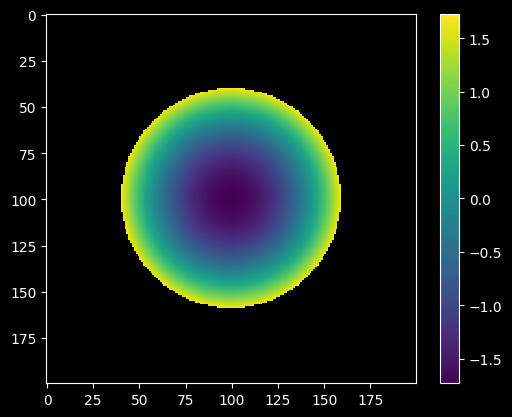

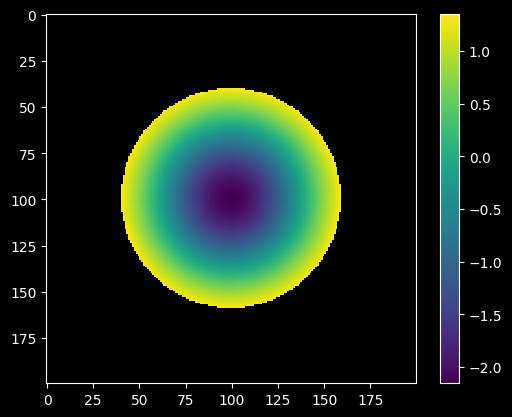

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(zcube[:,:,2])
plt.colorbar()
plt.figure()
plt.imshow(klcube[:,:,3])
plt.colorbar()



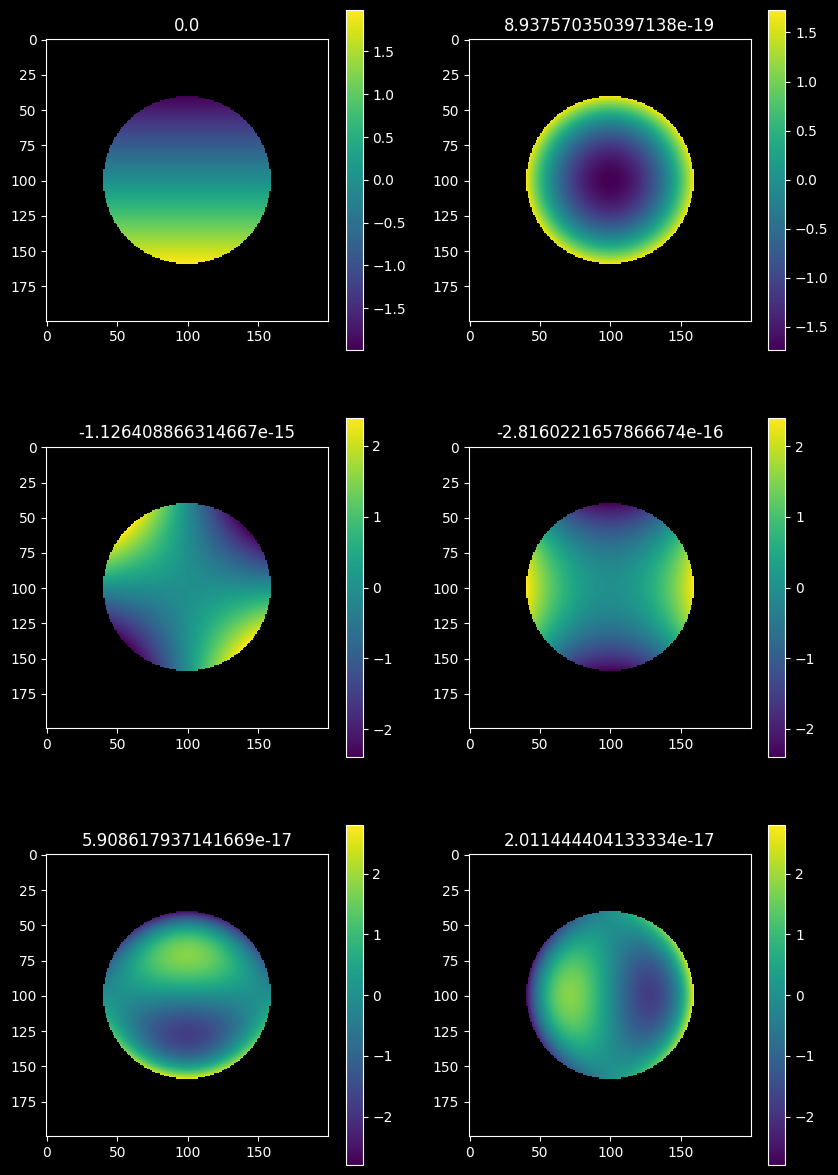

In [14]:

plt.figure(figsize=(10,15))
for ii in np.arange(1,7):
    plt.subplot(3,2,ii)
    plt.imshow(klcube[:,:,ii])
    plt.colorbar()
    plt.title(np.mean(klcube[:,:,ii-1] ))